In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import joblib
import dask
from dask import delayed, compute
from dask.distributed import Client
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath("../src"))
from backtesting_utils import *

In [2]:
# Load Models for Multiple Tickers
MODEL_PATHS = {
    "AAPL": "models/AAPL_improved_random_forest.pkl",
    "GOOGL": "models/GOOGL_improved_random_forest.pkl",
    "TSLA": "models/TSLA_improved_random_forest.pkl",
    "MSFT": "models/MSFT_improved_random_forest.pkl"
}

trained_models = {ticker: joblib.load(path) for ticker, path in MODEL_PATHS.items()}

In [3]:
# Start Dask Client
client = Client()
print("Dask Dashboard:", client.dashboard_link)

# File paths for datasets
DATA_PATHS = {
    "AAPL": "processed_data/AAPL_historical_prices_.csv",
    "GOOGL": "processed_data/GOOGL_historical_prices_.csv",
    "TSLA": "processed_data/TSLA_historical_prices_.csv",
    "MSFT": "processed_data/MSFT_historical_prices_.csv"
}

# Load datasets
datasets = {ticker: delayed(load_data)(path) for ticker, path in DATA_PATHS.items()}

# Run parallel backtesting
tasks = [
    delayed(run_backtest)(datasets[ticker], trained_models[ticker])
    for ticker in DATA_PATHS.keys()
]

backtest_results = compute(*tasks)

# Prepare results with ticker info
results_with_tickers = [
    {
        **result,
        'ticker': ticker
    }
    for result, ticker in zip(backtest_results, DATA_PATHS.keys())
]

# Print results
for result in results_with_tickers:
    print(
        f"Ticker: {result['ticker']}, Final Value: {result['final_value']}, "
        f"Sharpe Ratio: {result['sharpe_ratio']}, Max Drawdown: {result['max_drawdown']}%"
    )

Dask Dashboard: http://127.0.0.1:8787/status


/Users/anjalikhantaal/Desktop/Work/MBZUAI/pdml/parallel-distributed-ml-trading/venv/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 32.11 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Ticker: AAPL, Final Value: 10171.418966542486, Sharpe Ratio: -4.459065002169047, Max Drawdown: 0.34850107299954813%
Ticker: GOOGL, Final Value: 10073.532419438472, Sharpe Ratio: -5.528059723895856, Max Drawdown: 0.5038628819561239%
Ticker: TSLA, Final Value: 10199.185332536697, Sharpe Ratio: -1.2551135019255975, Max Drawdown: 1.7909067239694065%
Ticker: MSFT, Final Value: 10027.699624308747, Sharpe Ratio: -6.931762941096068, Max Drawdown: 0.49279353987533897%


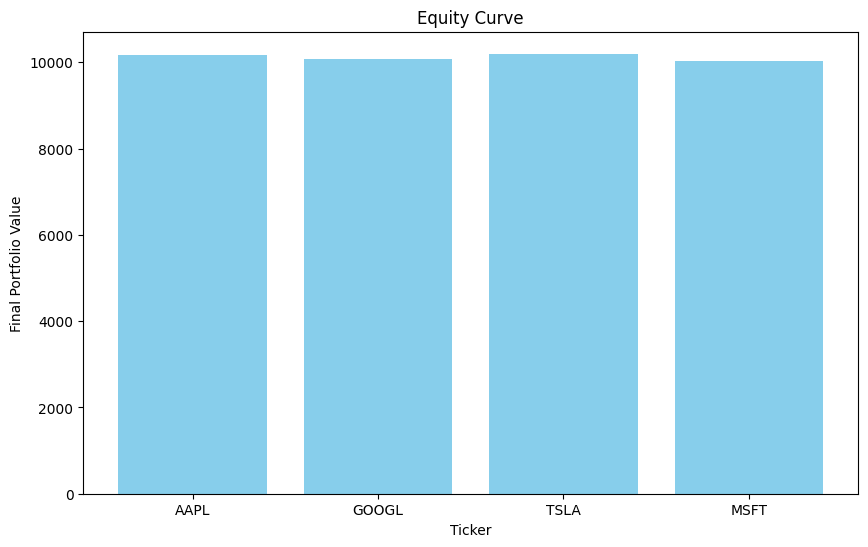

In [4]:
# Plot equity curve
plot_equity_curve(results_with_tickers)